In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.segments import * 
from trajectory.planner import * 
from trajectory.plot import * 
import matplotlib.pyplot as plt
from IPython.display import display
import trajectory as tj
import pandas as pd
from math import sqrt

In [2]:
# Test the error of the inital_parameters() function

from trajectory.planner import accel_tx, v_c_max, max_v0_for_x, inital_parameters

from random import randint, random



rows = []
for i in range(10000):
    v_max = randint(300,10000)
    a_max = randint(v_max*15,v_max*25)
    
    x = randint(10,v_max)
    v_0 = randint(0,v_max)
    v_1 = randint(0,v_max)
    
    args = (x, v_0, v_max, v_1, a_max)
    r = inital_parameters(*args)

    d = { k:v for k,v in zip('x_in v_0_in v_c_in v_1_in a_max'.split(),args)}
    d.update(r._asdict())
    rows.append(d)
        
df = pd.DataFrame(rows)
df['x_r'] = df.x_a + df.x_c + df.x_d
df['eq'] = df.x_in == df.x_r
df['err'] =  ((df.x_in - df.x_r).abs()/df.x_in) 
t = df[ (df.is_triangle==True) & (df['eq'] == False) ].copy()


assert df.err.mean() < .001 # Less than .1 %
df.err.mean()

0.0006865323171630947

In [3]:
# Run 1000 random moves on 6 joints

import datetime

N = 1000

sl = SegmentList([Joint(5_000, 50_000),
                  Joint(10_000, 200_000),
                  Joint(10_000, 20_000),
                  Joint(5_000, 50_000),
                  Joint(5_000, 50_000),
                  Joint(5_000, 50_000)
                 ]
                )


moves = [ [randint(-2000,2000) for _ in sl.joints] for i in range(N) ]

start = datetime.datetime.now()

for move  in moves:
    
    try:
        sl.rmove(move)
    except Exception as e:
        print(move)
        raise

finish = datetime.datetime.now()
print( (finish-start)/N)

#plot_segment_list(sl.dataframe)
#sl.dataframe.sample(10)

0:00:00.000156


In [4]:
# Test random segments, without segment-to-segment interactions

N = 2000

inputs = []

sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   

for i in range(N):
    moves = [randint(-2000,2000) for _ in sl.joints] 

    limits = []
    for j in sl.joints:
        v_0_max = randint(0,j.v_max)
        v_0 = randint(0,j.v_max)
        v_1_max = randint(0,j.v_max)
        limits.append( (v_0_max, v_0 , v_1_max) )
        
    inputs.append( (moves, limits) )
            
frames = []

def test_sl(moves, limits):
    from trajectory.planner import ValidationError, ConvergenceError
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    s = sl.rmove(moves)  
    
    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max
        
    s.update()
    
    sl.validate()
    
    return s


for i, (moves, limits) in enumerate(inputs):

    try:
        s = test_sl(moves, limits)
        frames.append(s.params)
    except Exception as e:
        print('E ', type(e), i, e)

df = pd.concat(frames)
df[df.err_x > 1].sort_values('err_x', ascending=False)


,seg,js,seg_t,x,t,dir,v_0_max,v_0,x_a,t_a,...,v_c_max,v_c,x_d,t_d,v_1,v_1_max,calc_x,sum_x,calc_t,err_x
2,0,2,0.3062,180,0.3062,1,4243,1620,25.205585,0.02596,...,5000,552,0.000000,0.00000,552,2930,183,180,0.303451,2.9863
0,0,0,0.2772,162,0.2772,-1,1861,1764,30.068014,0.02880,...,5000,531,0.000000,0.00000,531,2791,165,162,0.274599,2.9848
0,0,0,0.3312,359,0.3312,-1,4066,3329,104.580566,0.05078,...,5000,907,0.000000,0.00000,907,4901,362,359,0.329795,2.9762
0,0,0,0.3464,380,0.3464,-1,1449,1449,16.069733,0.01494,...,5000,1098,0.000000,0.00000,1098,4804,383,380,0.344076,2.9593
1,0,1,0.3948,478,0.3948,1,2456,146,4.745387,0.01116,...,5000,1234,0.000000,0.00000,1234,4542,481,478,0.390516,2.9551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0,1,0.3562,1281,0.3562,-1,2670,413,190.830622,0.07950,...,5000,4401,185.680472,0.07120,828,828,1282,1281,0.355796,1.0112
2,0,2,0.4618,1809,0.4618,-1,413,413,179.186163,0.07680,...,5000,4273,88.779603,0.02436,3035,3035,1810,1809,0.461406,1.0107
2,0,2,0.3914,1457,0.3914,-1,1001,1001,147.937880,0.05947,...,5000,3998,87.361400,0.02635,2657,2657,1458,1457,0.391027,1.0094
1,0,1,0.3414,426,0.3414,-1,751,163,0.205576,0.00171,...,5000,1253,0.000000,0.00000,1194,1194,427,426,0.339981,1.0050


[-1817, -153, 1052] [(3296, 874, 9), (1509, 3595, 2471), (695, 1347, 2551)]


/Users/eric/Documents/proj/trajectory/trajectory/planner.py:1151: UserWarning: 0/0 Excessive error. err_x=43.700000000000216 re=0.024050632911392523
  warn(str(e))


,t,seg,axis,x,v0m,v_i,v_f,v1m,ss,del_t,calc_x,err
0,0.076893,0,0,215.0,3296,874.00,4718.65,9,a,0.076893,215.017539,-0.017539
1,0.369207,0,0,1379.0,3296,4718.65,4718.65,9,c,0.292314,1379.328400,-0.328400
2,0.463400,0,0,223.0,3296,4718.65,9.00,9,d,0.094193,222.655532,0.344468
3,0.027269,0,1,23.0,1509,1509.00,299.09,2471,a,0.027269,24.652855,-1.652855
4,0.463400,0,1,130.0,1509,299.09,299.09,2471,c,0.436130,130.442271,-0.442271
5,0.463400,0,1,0.0,1509,299.09,299.09,2471,d,0.000000,0.000000,0.000000
6,0.032607,0,2,49.0,695,695.00,2327.70,2551,a,0.032607,49.281043,-0.281043
7,0.463400,0,2,1003.0,695,2327.70,2327.70,2551,c,0.430793,1002.756168,0.243832
8,0.463400,0,2,0.0,695,2327.70,2327.70,2551,d,0.000000,0.000000,0.000000


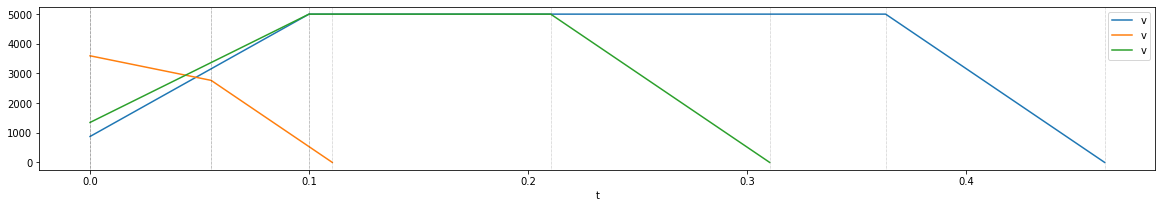

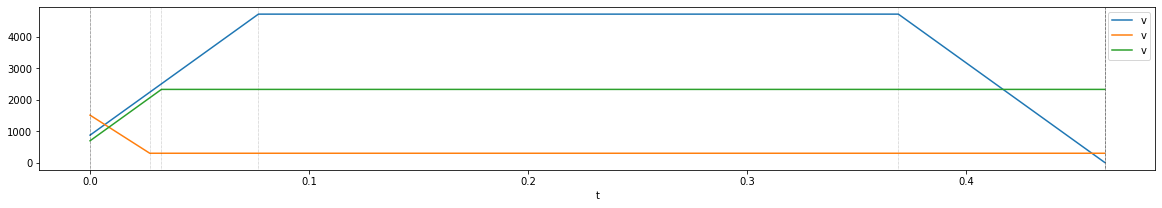

In [5]:
from trajectory.planner import max_v0_for_x
moves, limits = inputs[82]

print(moves, limits)

from trajectory.planner import ValidationError, ConvergenceError
sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   
s = sl.rmove(moves)  

for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
    js.v_0_max = v_0_max
    js.v_0 = v_0
    js.v_1_max = v_1_max

plot_segment_list(sl.dataframe)

if not s.update(_warn=False):
    warn('Failed to converge in error reduction')
    
plot_segment_list(sl.dataframe)

sl.dataframe
